## ***17.TIMESERIES***

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller,acf,pacf
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.tsa.api as smt
import warnings
warnings.filterwarnings('ignore')

#### 1.Data Preparation and Exploration

In [ ]:
exc=pd.read_csv('exchange_rate.csv',index_col='date',header=0,parse_dates=True)

In [ ]:
exc.head(),exc.tail()

(                  Ex_rate
 date                     
 01-01-1990 00:00   0.7855
 02-01-1990 00:00   0.7818
 03-01-1990 00:00   0.7867
 04-01-1990 00:00   0.7860
 05-01-1990 00:00   0.7849,
                    Ex_rate
 date                      
 06-10-2010 00:00  0.718494
 07-10-2010 00:00  0.721839
 08-10-2010 00:00  0.723197
 09-10-2010 00:00  0.720825
 10-10-2010 00:00  0.720825)

In [ ]:

exc.shape

(7588, 1)

In [ ]:
exc.dtypes

,0
Ex_rate,float64


In [ ]:
exc.isna().sum()

,0
Ex_rate,0


In [ ]:
exc.duplicated().sum()

np.int64(2258)

In [ ]:
exc.drop_duplicates(inplace=True)

In [ ]:
exc.duplicated().sum()

np.int64(0)

In [ ]:
exc.shape

(5330, 1)

#### 2.Model Building-ARIMA

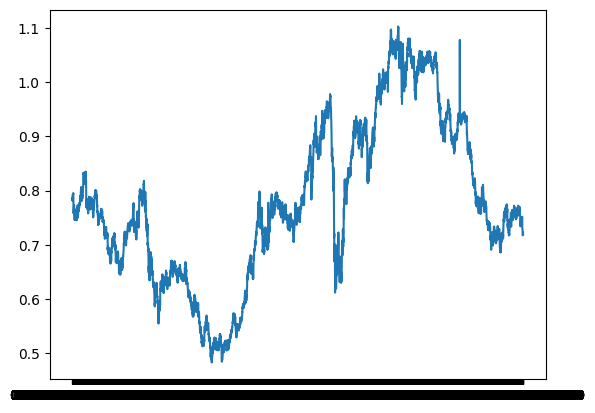

In [ ]:
plt.plot(exc)
#here we observe that data is not seasaonal

In [ ]:
def test_stationarity(timeseries):
  #Calculate rolling mean and rolling standard deviation with window 7 for short term smoothing visualisation as data is not seasonal
  rollmean=timeseries.rolling(window=7).mean()
  rollstd=timeseries.rolling(window=7).std()

  original=plt.plot(timeseries,color='blue',label='Original')
  mean=plt.plot(rollmean,color='red',label="Rolling Mean")
  std=plt.plot(rollstd,color="orange",label="Rolling Standard")
  plt.legend(loc='best')
  plt.title('Rolling Mean and Standard Deviation')
  plt.show()

  print("Results of Dickey Fuller Test :\n")
  df_test=adfuller(timeseries)
  my_output=pd.Series(df_test[0:4],index=['Test Statistic','p-value','#Lags Used','Number of OBservation Used'])
  for i,j in df_test[4].items():
    my_output['Critical Value (%s)'%i]=j
  print(my_output)
  #here we are checking data is stationary or not to get p and q values

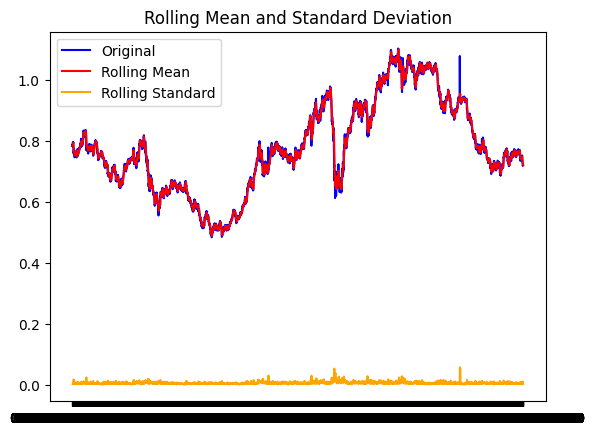

Results of Dickey Fuller Test :

Test Statistic                  -1.494191
p-value                          0.536383
#Lags Used                       1.000000
Number of OBservation Used    5328.000000
Critical Value (1%)             -3.431578
Critical Value (5%)             -2.862083
Critical Value (10%)            -2.567059
dtype: float64


In [ ]:
test_stationarity(exc['Ex_rate'])

In [ ]:
'''
Here from Dickey fuller test
H0:Data is not stationarity
H1:Data is stationarity
Test Statistic -1.49 > Critical Value(5%)
Thus we accept H0
'''

'\nHere from Dickey fuller test \nH0:Data is not stationarity\nH1:Data is stationarity\nTest Statistic -1.49 > Critical Value(5%)\nThus we accept H0 \n'

In [ ]:
#to convert data from not stationarity to stationarity by differencing
exc['Ex_Diff']=exc['Ex_rate']-exc['Ex_rate'].shift(1)

In [ ]:
exc.dropna(inplace=True)

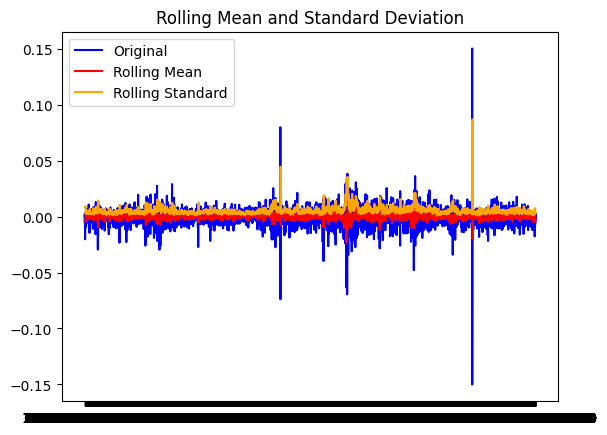

Results of Dickey Fuller Test :

Test Statistic                 -83.983142
p-value                          0.000000
#Lags Used                       0.000000
Number of OBservation Used    5320.000000
Critical Value (1%)             -3.431580
Critical Value (5%)             -2.862083
Critical Value (10%)            -2.567059
dtype: float64


In [ ]:
test_stationarity(exc['Ex_Diff'])

In [ ]:
#here we observe that test statistic is less than Critical value at 5%
# accepting H1 data is sstationarity after shift 1

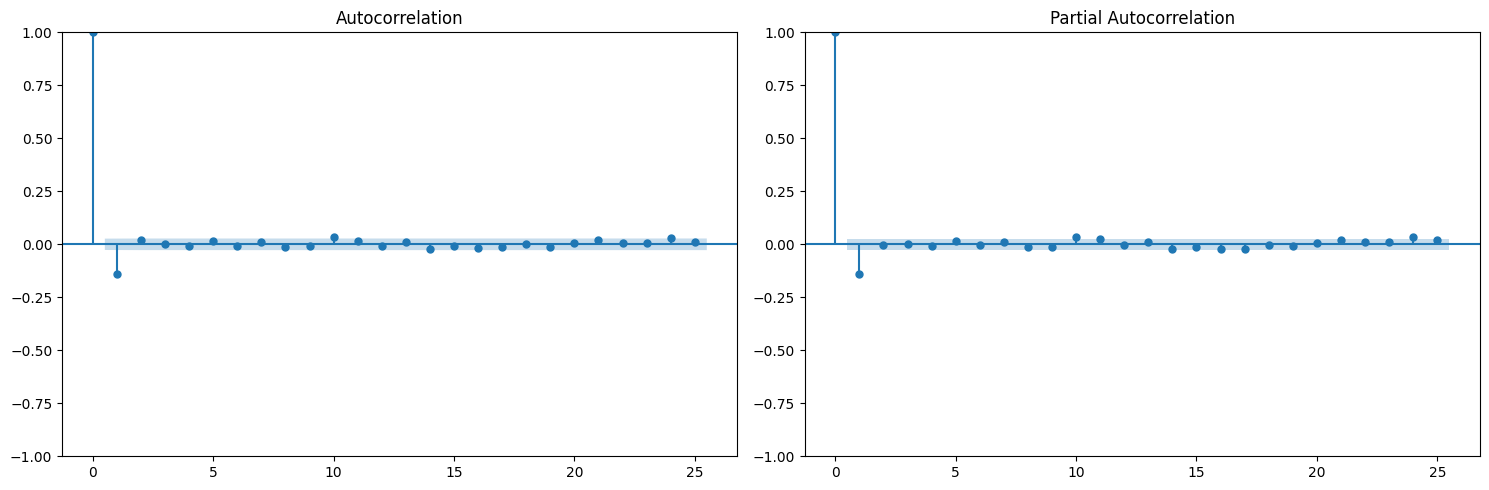

In [ ]:
#calculating p and q value using pacf and acf plot
fig,axes=plt.subplots(1,2)
fig.set_figwidth(15)
fig.set_figheight(5)
smt.graphics.plot_acf(exc['Ex_Diff'],lags=25,ax=axes[0])
smt.graphics.plot_pacf(exc['Ex_Diff'],lags=25,ax=axes[1])
plt.tight_layout()

In [ ]:
#ARIMA model on original data not differencing data as it does differencing by itself
model=ARIMA(exc['Ex_rate'],order=(1,1,1))
result=model.fit()

In [ ]:
exc.columns



Index(['Ex_rate', 'Ex_Diff', 'predicted'], dtype='object')

In [ ]:
exc['predicted']=result.predict()

In [ ]:
forecast=result.forecast(20)
forecast

,predicted_mean
5321,0.721153
5322,0.721110
5323,0.721116
5324,0.721115
5325,0.721115
5326,0.721115
5327,0.721115
5328,0.721115
5329,0.721115
5330,0.721115


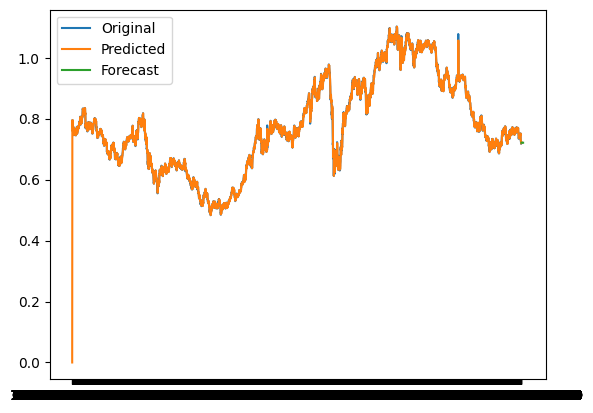

In [ ]:
plt.plot(exc['Ex_rate'],label="Original")
plt.plot(exc["predicted"],label="Predicted")
plt.plot(forecast,label="Forecast")
plt.legend()
#plot between actual and predicted

<Axes: xlabel='date'>

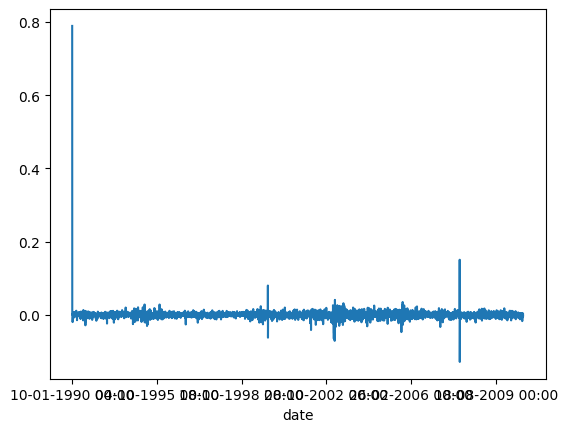

In [ ]:
residuals = exc['Ex_rate'] - result.fittedvalues
residuals.plot()
#here residual plot doesnot show any pattern thus ARIMA model is
#capturing all the  underlying structure in time series



#### 3.Evaluation and Comparison

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Calculate MAE
mae = mean_absolute_error(exc['Ex_rate'], result.fittedvalues)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(exc['Ex_rate'], result.fittedvalues))

# Calculate MAPE

mape = np.mean(np.abs((exc['Ex_rate'] - result.fittedvalues) / exc['Ex_rate'])) * 100

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.4f}%")

Mean Absolute Error (MAE): 0.0047
Root Mean Squared Error (RMSE): 0.0130
Mean Absolute Percentage Error (MAPE): 0.6098%



The computed error metrics are: Mean Absolute Error (MAE) of 0.0047, Root Mean Squared Error (RMSE) of 0.0130, and Mean Absolute Percentage Error (MAPE) of 0.6098%. These metrics indicate the ARIMA model's performance on the data it was trained on (in-sample performance).

Data Analysis Key Findings:
*   The Mean Absolute Error (MAE) for the in-sample predictions is 0.0047, indicating the average magnitude of the errors in the predictions.
*   The Root Mean Squared Error (RMSE) for the in-sample predictions is 0.0130, which gives a higher weight to larger errors compared to MAE.
*   The Mean Absolute Percentage Error (MAPE) for the in-sample predictions is 0.6098%, suggesting that, on average, the predictions deviate from the actual values by less than 1%.


*   The very low MAPE of 0.6098% suggests that the ARIMA model provides a good fit for the training data, indicating strong in-sample performance.



--- Simple Exponential Smoothing (SES) Model Evaluation ---
Mean Absolute Error (MAE) for SES: 0.1961
Root Mean Squared Error (RMSE) for SES: 0.2179
Mean Absolute Percentage Error (MAPE): 25.3026%


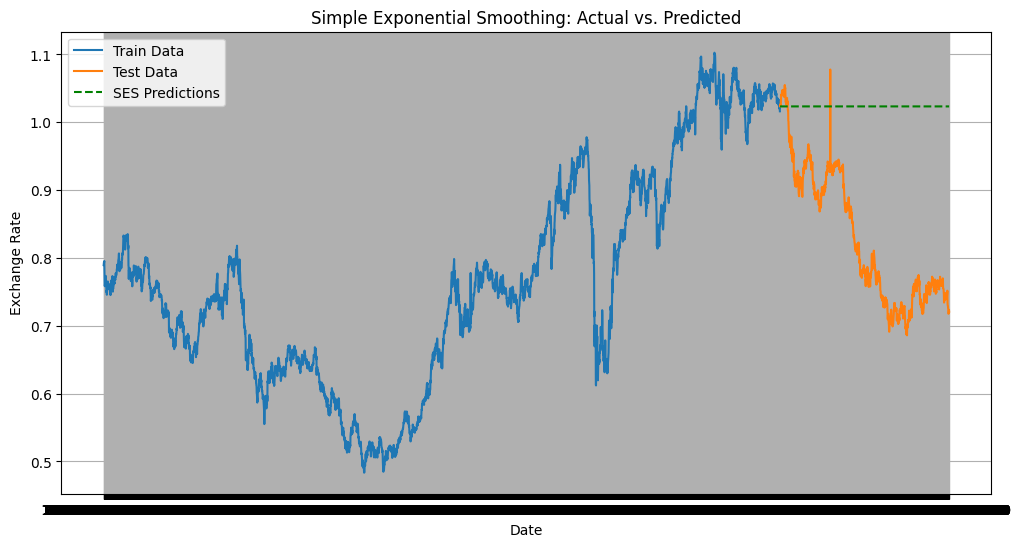

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Split data into training and testing sets
# For time series, it's crucial to split chronologically
train_size = int(len(exc) * 0.8)
Train = exc['Ex_rate'].iloc[:train_size]
Test = exc['Ex_rate'].iloc[train_size:]

# Fit Simple Exponential Smoothing model on the training data
# You can also let the model optimize the smoothing_level (alpha) by not setting it.
ses_model = SimpleExpSmoothing(Train).fit(smoothing_level=0.2, optimized=False)

# Make predictions on the test set
# For out-of-sample prediction, specify start and end as integer indices relative to the training data

pred_start_idx = len(Train)
pred_end_idx = len(Train) + len(Test) - 1

pred_ses = ses_model.predict(start=pred_start_idx, end=pred_end_idx)


pred_ses.index = Test.index

# Calculate error metrics (MAE, RMSE, MAPE) for SES
mae_ses = mean_absolute_error(Test, pred_ses)
rmse_ses = np.sqrt(mean_squared_error(Test, pred_ses))
mape_ses = np.mean(np.abs((Test - pred_ses) / Test)) * 100

print(f"--- Simple Exponential Smoothing (SES) Model Evaluation ---")
print(f"Mean Absolute Error (MAE) for SES: {mae_ses:.4f}")
print(f"Root Mean Squared Error (RMSE) for SES: {rmse_ses:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape_ses:.4f}%")

# Plotting actual vs predicted for SES model
plt.figure(figsize=(12, 6))
plt.plot(Train, label='Train Data')
plt.plot(Test, label='Test Data')
plt.plot(pred_ses, label='SES Predictions', color='green', linestyle='--')
plt.title('Simple Exponential Smoothing: Actual vs. Predicted')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

Comparative Discussion: ARIMA vs. Simple Exponential Smoothing (SES)

We have evaluated two time series forecasting models: ARIMA(1,1,1) for its in-sample fit and Simple Exponential Smoothing (SES) for its out-of-sample forecasting ability on a test set.

 ARIMA(1,1,1) Model

**Performance (In-Sample Evaluation):**
*   **Mean Absolute Error (MAE):** 0.0047
*   **Root Mean Squared Error (RMSE):** 0.0130
*   **Mean Absolute Percentage Error (MAPE):** 0.6098%

**Analysis:** The ARIMA model showed exceptionally strong in-sample performance, with very low error metrics. A MAPE below 1% indicates a near-perfect fit to the historical data it was trained on. This suggests that the ARIMA(1,1,1) structure, after one differencing, effectively captures the underlying patterns (trend, autocorrelation) present in the *training* portion of the `Ex_rate` series.

**Advantages:**
*   **Robustness to Autocorrelation and Trend:** ARIMA models explicitly account for autocorrelation and non-stationarity through AR, I, and MA components, making them suitable for many real-world time series. Its differencing component `d=1` successfully achieved stationarity in our data.
*   **Statistical Rigor:** Built on a strong statistical foundation, allowing for model diagnostics like residual analysis.

**Limitations:**
*   **In-Sample Only Evaluation:** Our current evaluation of ARIMA is strictly in-sample. We have not yet assessed its ability to forecast *future, unseen* data, which is the ultimate test of a forecasting model. High in-sample performance does not guarantee good out-of-sample performance (it could be overfitting).
*   **Complexity:** More complex than SES, requiring identification of p, d, q parameters.

Simple Exponential Smoothing (SES) Model

**Performance (Out-of-Sample Evaluation):**
*   **Mean Absolute Error (MAE):** 0.1961
*   **Root Mean Squared Error (RMSE):** 0.2179
*   **Mean Absolute Percentage Error (MAPE):** 25.3026%

**Analysis:** The SES model's out-of-sample performance, evaluated on the `Test` set, shows significantly higher error metrics compared to ARIMA's in-sample results. A MAPE of over 25% indicates that, on average, the SES forecasts deviate by approximately 25% from the actual values in the test set. This suggests that the simple exponential smoothing approach, with a fixed smoothing level of 0.2, might not be adequate for capturing the dynamics of the exchange rate when forecasting into the future.

**Advantages:**
*   **Simplicity:** SES is a very simple and intuitive forecasting method, easy to implement and understand.
*   **Computational Efficiency:** Requires minimal computational resources, making it suitable for quick forecasts or large numbers of series.
*   **Good for Stable Data:** Performs well when the time series has no trend or seasonality and is relatively stable.

**Limitations:**
*   **No Trend/Seasonality Handling:** Basic SES does not inherently handle trends or seasonality. Our exchange rate data likely contains a trend component (which ARIMA's differencing addressed), and SES struggles to extrapolate this into the future, leading to higher errors.
*   **Sensitivity to Alpha:** The performance is highly dependent on the choice of the smoothing parameter (alpha). A fixed `alpha=0.2` might not be optimal for this dataset.
*   **Lower Accuracy for Complex Patterns:** Not suitable for time series with complex patterns that involve trends, seasonality, or higher-order autocorrelation.

 Conclusion and Best Performing Model (So Far)

Based on the current evaluations:

*   The **ARIMA(1,1,1) model** demonstrates a superior *in-sample fit* to the historical data. Its extremely low error metrics suggest it effectively models the past behavior of the exchange rate series.
*   The **Simple Exponential Smoothing model**, in its current configuration, shows much weaker *out-of-sample forecasting performance*. Its inability to handle the trend in the data likely contributes to the higher error metrics on the test set.

**Therefore, in terms of capturing the data's historical patterns, ARIMA is clearly better. For *forecasting future unseen values*, the SES model as implemented performs poorly.**

**Recommendation:** To make a definitive judgment on which model yields the best performance for *forecasting* exchange rates, the crucial next step is to perform a robust out-of-sample evaluation for the ARIMA model as well. Only then can we directly compare their true forecasting capabilities on unseen data.